# Coral Bleaching
# Preprocessing



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC

In [2]:
# import data
df = pd.read_csv('../data/interim/coral_bleaching_cleaned_v2.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34251 entries, 0 to 34250
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Latitude_Degrees            34251 non-null  float64
 1   Longitude_Degrees           34251 non-null  float64
 2   Ocean_Name                  34251 non-null  object 
 3   Realm_Name                  34251 non-null  object 
 4   Country_Name                34251 non-null  object 
 5   State_Island_Province_Name  34187 non-null  object 
 6   Distance_to_Shore           34249 non-null  float64
 7   Turbidity                   34251 non-null  float64
 8   Cyclone_Frequency           34251 non-null  float64
 9   Date_Year                   34251 non-null  int64  
 10  Depth_m                     32643 non-null  float64
 11  Percent_Bleaching           34251 non-null  float64
 12  Windspeed                   34251 non-null  float64
 13  SSTA                        342

### Drop Unnecessary Columns and NaNs
The current data still has a few categorical features and some missing values that need to be handled. Since there are only two values missing from Distance_to_Shore, I will drop these missing values. However, I will impute missing Depth_m values based on medians by Realm_Name. 

I have decided to use Realm_Name as the regional feature, which will ultimately be converted using one-hot encoding. The remaining spatial features - Latitude_Degrees, Longitude_Degrees, Ocean_Name, Country_Name, State_Island_Province_Name - and be remove. Additionally, Date and Date_Year can be removed. 

In [3]:
# Keep Realm_Name for imputing and one-hot encoding
# drop remaining object features

df_2 = df.drop(columns=['Latitude_Degrees', 'Longitude_Degrees','Ocean_Name', 'Country_Name', 
                          'Date', 'State_Island_Province_Name', 'Date_Year', 'Percent_Bleaching'], axis=1)

# drop observations missing distance to shore
df_2 = df_2[df_2['Distance_to_Shore'].notna()] 
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34249 entries, 0 to 34250
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Realm_Name             34249 non-null  object 
 1   Distance_to_Shore      34249 non-null  float64
 2   Turbidity              34249 non-null  float64
 3   Cyclone_Frequency      34249 non-null  float64
 4   Depth_m                32641 non-null  float64
 5   Windspeed              34249 non-null  float64
 6   SSTA                   34249 non-null  float64
 7   SSTA_Frequency         34249 non-null  float64
 8   SSTA_DHW               34249 non-null  float64
 9   TSA                    34249 non-null  float64
 10  TSA_Frequency          34249 non-null  float64
 11  TSA_DHW                34249 non-null  float64
 12  Temperature_C          34249 non-null  float64
 13  Temperature_Maximum_C  34249 non-null  float64
 14  Bleaching_indicator    34249 non-null  int64  
 15  Ex

<AxesSubplot: >

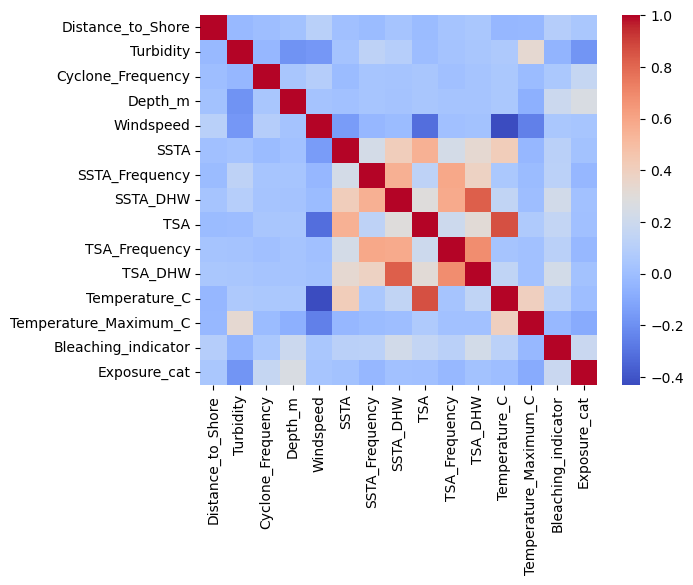

In [4]:
sns.heatmap(df_2.corr(numeric_only=True), cmap='coolwarm')

As represented in this correlation heatmap, Temperature_C is positively correlated with TSA and TSA_DHW is positively correlated with SSTA_DHW. TSA_Frequency is also slightly correlated with a few other temperature measures. I will drop Temperature_C, TSA_DHW, and TSA_Frequency since they can be accounted for through the other corresponding features. 

<AxesSubplot: >

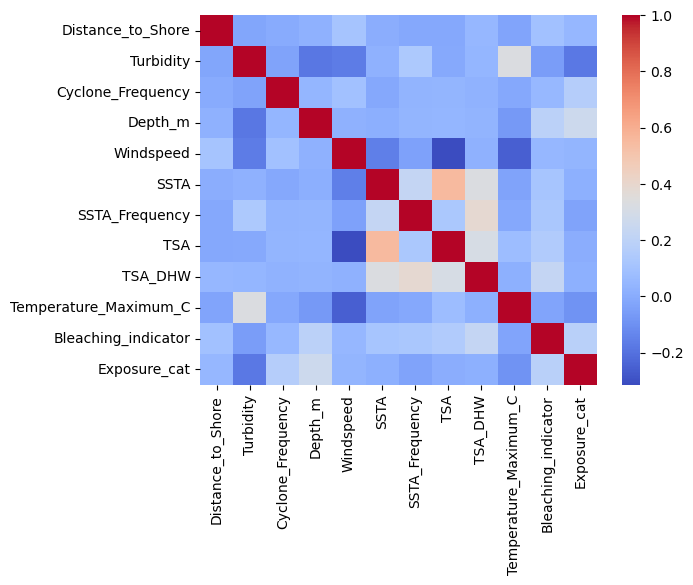

In [5]:
df_2 = df_2.drop(columns=['Temperature_C', 'SSTA_DHW', 'TSA_Frequency'], axis=1)
sns.heatmap(df_2.corr(numeric_only=True), cmap='coolwarm')

Text(0.5, 1.0, 'Missing Depth Values by Realm')

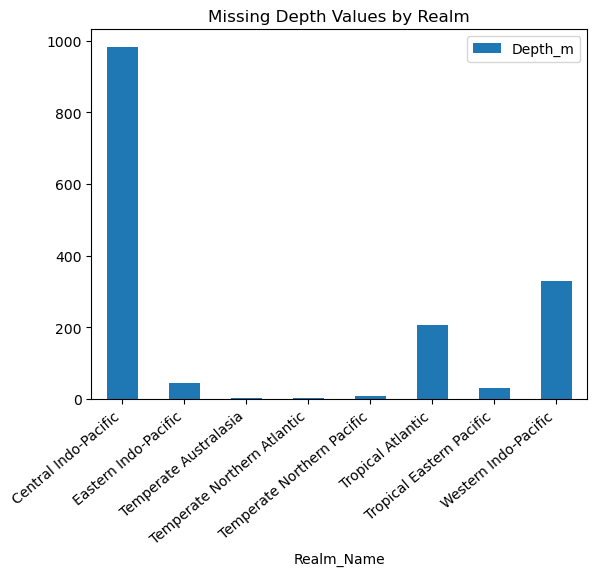

In [6]:
realms = pd.DataFrame(df_2['Depth_m'].isnull().groupby([df_2['Realm_Name']]).sum())
realms.plot.bar()
plt.xticks(rotation=40, ha='right')
plt.title('Missing Depth Values by Realm')

## Undersampling & Oversampling (SMOTE)

Due to the imbalance in Bleaching_indicator (70/30), I will use undersampling to work with a more balanced target variable. The data can then be split into training and test sets. 

In [7]:
X = df_2.drop(columns=['Bleaching_indicator'])
y = df_2['Bleaching_indicator']

# Undersample data to counteract imbalance
# i.e. select fewer Bleaching_indicator == 0 observations
rus = RandomUnderSampler(random_state=5)
X_under, y_under = rus.fit_resample(X, y)


# Oversample/SMOTE
df_3 = df_2.dropna()
X2 = df_3.drop(columns=['Bleaching_indicator'])
y2 = df_3['Bleaching_indicator']
smote = SMOTENC(categorical_features=['Realm_Name'], random_state=5)
X_over, y_over = smote.fit_resample(X2, y2)


## Preprocessing Steps:
1. train_test_split
2. impute missing Depth_m values using median by Realm_Name
3. scaling option
4. encode Realm_Name

In [9]:
def fill_missing_depth(X, medians):
    '''
    Replace missing depth values with median by Realm input.
    '''
    col = X.columns.get_loc('Depth_m')
    
    for i in range(len(X)):
        if X['Depth_m'].isnull().iloc[i]:
            realm = X['Realm_Name'].iloc[i]
            median = medians[realm]
            X.iloc[i, col] = median
        else:
            pass
        
    return X



def scale_data(X_train, X_test):
    '''
    StandardScaler on numeric features, fit on train data, 
    transforms both train and test. 
    '''
    scale_columns = ['Distance_to_Shore', 'Turbidity', 'Cyclone_Frequency', 
                     'Depth_m','Windspeed', 'SSTA', 'SSTA_Frequency', 
                     'TSA_DHW', 'TSA', 'Temperature_Maximum_C', 'Exposure_cat']
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[scale_columns])
    X_test_scaled = scaler.transform(X_test[scale_columns])
    
    X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=scale_columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=scale_columns)
    
    # add Realm_Name back to scaled data for complete list of features
    X_train_scaled_df['Realm_Name'] = X_train['Realm_Name']
    X_test_scaled_df['Realm_Name'] = X_test['Realm_Name']
    
    
    return X_train_scaled_df, X_test_scaled_df




def preprocess_data(X, y, scale=True):
    '''
    1. Train/Test Split 80/20
    2. Impute missing depth with train median by Realm
    3. Scale if indicated
    4. One-hot encode Realm_Name
    '''
    
    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
    
    # Impute missing Depth_m values
    realm_depth_median = X_train.groupby(by=['Realm_Name']).median()['Depth_m']

    X_train = fill_missing_depth(X_train, realm_depth_median)
    X_test = fill_missing_depth(X_test, realm_depth_median)
    
    
    if scale:
        X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

        # on-hot encode Realm_Name
        X_train_scaled = pd.get_dummies(X_train_scaled, columns=['Realm_Name'], prefix='Realm')
        X_test_scaled = pd.get_dummies(X_test_scaled, columns=['Realm_Name'], prefix='Realm')
    
        return X_train_scaled, X_test_scaled, y_train, y_test

    else:
        X_train = pd.get_dummies(X_train, columns=['Realm_Name'], prefix='Realm')
        X_test = pd.get_dummies(X_test, columns=['Realm_Name'], prefix='Realm')

        return X_train, X_test, y_train, y_test


    
    
def check_preprocessing(X_train, X_test, y_train, y_test):
    '''
    check for null values, number of observations, and bleaching indicator balance
    '''
    
    # check missing values
    missing_train = X_train.isnull().sum().sum()
    missing_test = X_test.isnull().sum().sum()
    
    print(f'There are {missing_train + missing_test} missing feature value(s).')
    print('')
    
    
    # check number of rows/observations 
    train_rows = X_train.shape[0]
    test_rows = X_test.shape[0]
    
    print(f'Train observations: {train_rows}')
    print(f'Test observations:  {test_rows}')
    print('')
    
    
    # check Bleaching_indicator balance 
    train_balance = y_train.value_counts(normalize=True, sort=False)
    test_balance = y_test.value_counts(normalize=True, sort=False)
    
    print(f'Train Bleaching Indicator: {round(train_balance[0],2)} / {round(train_balance[1],2)}')
    print(f'Test Bleaching Indicator:  {round(test_balance[0],2)} / {round(test_balance[1],2)}')
    


In [10]:
# Process Undersampling without scaling
X_tr_under, X_ts_under, y_tr_under, y_ts_under = preprocess_data(X_under, y_under, scale=False)
check_preprocessing(X_tr_under, X_ts_under, y_tr_under, y_ts_under)

There are 0 missing feature value(s).

Train observations: 16008
Test observations:  4002

Train Bleaching Indicator: 0.5 / 0.5
Test Bleaching Indicator:  0.49 / 0.51


In [11]:
# Process Oversampling without scaling
X_tr_over, X_ts_over, y_tr_over, y_ts_over = preprocess_data(X_over, y_over, scale=False)
check_preprocessing(X_tr_over, X_ts_over, y_tr_over, y_ts_over)

There are 0 missing feature value(s).

Train observations: 38660
Test observations:  9666

Train Bleaching Indicator: 0.5 / 0.5
Test Bleaching Indicator:  0.49 / 0.51


In [12]:
# Process Undersampling with scaling
X_tr_under_scl, X_ts_under_scl, y_tr_under_scl, y_ts_under_scl = preprocess_data(X_under, y_under, scale=True)
check_preprocessing(X_tr_under_scl, X_ts_under_scl, y_tr_under_scl, y_ts_under_scl)

There are 0 missing feature value(s).

Train observations: 16008
Test observations:  4002

Train Bleaching Indicator: 0.5 / 0.5
Test Bleaching Indicator:  0.49 / 0.51


In [13]:
# Process Oversampling with scaling
X_tr_over_scl, X_ts_over_scl, y_tr_over_scl, y_ts_over_scl = preprocess_data(X_over, y_over, scale=True)
check_preprocessing(X_tr_over_scl, X_ts_over_scl, y_tr_over_scl, y_ts_over_scl)

There are 0 missing feature value(s).

Train observations: 38660
Test observations:  9666

Train Bleaching Indicator: 0.5 / 0.5
Test Bleaching Indicator:  0.49 / 0.51


In [14]:
# confirm scaled and unscaled target data are the same
print(f'Undersampled y_train differences:  {(y_tr_under.index != y_tr_under_scl.index).sum()}')
print(f'Undersampled y_test differences:   {(y_ts_under.index != y_ts_under_scl.index).sum()}')
print(f'Overersampled y_train differences: {(y_tr_over.index != y_tr_over_scl.index).sum()}')
print(f'Oversampled y_test differences:    {(y_ts_over.index != y_ts_over_scl.index).sum()}')

Undersampled y_train differences:  0
Undersampled y_test differences:   0
Overersampled y_train differences: 0
Oversampled y_test differences:    0


## Save Data

In [15]:
datapath = '../data/processed/'


# Undersampled Data
sample_type = 'undersample_data/'

X_tr_under.to_csv(str(datapath + sample_type)+'X_train_data.csv')
X_tr_under_scl.to_csv(str(datapath + sample_type)+'X_train_scaled_data.csv')
y_tr_under.to_csv(str(datapath + sample_type)+'y_train_data.csv')

X_ts_under.to_csv(str(datapath + sample_type)+'X_test_data.csv')
X_ts_under_scl.to_csv(str(datapath + sample_type)+'X_test_scaled_data.csv')
y_ts_under.to_csv(str(datapath + sample_type)+'y_test_data.csv')


# Oversampled/SMOTE data
sample_type = 'oversample_data/'

X_tr_over.to_csv(str(datapath + sample_type)+'X_train_data.csv')
X_tr_over_scl.to_csv(str(datapath + sample_type)+'X_train_scaled_data.csv')
y_tr_over.to_csv(str(datapath + sample_type)+'y_train_data.csv')

X_ts_over.to_csv(str(datapath + sample_type)+'X_test_data.csv')
X_ts_over_scl.to_csv(str(datapath + sample_type)+'X_test_scaled_data.csv')
y_ts_over.to_csv(str(datapath + sample_type)+'y_test_data.csv')



# index is maintained, remember to reassign in pd.read_csv 
# pd.read_csv([file], index_col = 'Unnamed: 0')
